# Notebook for sample test of multiregressor


In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
# import lime.lime_tabular as lime_tab
# import lime.lime_tabular_mod as lime_tab
import lime.lime_tabular_multiregressor as lime_tab

import matplotlib.pyplot as plt
import random

import importlib
importlib.reload(lime_tab)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
22,4.6,3.6,1.0,0.2,Iris-setosa
96,5.7,2.9,4.2,1.3,Iris-versicolor
21,5.1,3.7,1.5,0.4,Iris-setosa
38,4.4,3.0,1.3,0.2,Iris-setosa
114,5.8,2.8,5.1,2.4,Iris-virginica
...,...,...,...,...,...
33,5.5,4.2,1.4,0.2,Iris-setosa
117,7.7,3.8,6.7,2.2,Iris-virginica
115,6.4,3.2,5.3,2.3,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica


### Prepare dataset 

In [3]:
labels_column_name = "label"
jackknife_idx = random.choice(iris_dataset.index.to_numpy())
# jackknife_idx = 118
train_data = iris_dataset.loc[iris_dataset.index != jackknife_idx]
train_x = train_data.drop(columns=labels_column_name).to_numpy()
train_y = train_data[labels_column_name].to_numpy()
test_data = iris_dataset.loc[iris_dataset.index == jackknife_idx]
test_x = test_data.drop(columns=labels_column_name).to_numpy()
test_y = test_data[labels_column_name].to_numpy()

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
print(f"Attributes: {attributes}")

Attributes: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


In [4]:
model = sklearn.ensemble.RandomForestClassifier()
model.fit(train_x, train_y)

result = model.predict(test_x)
accuracy = sklearn.metrics.accuracy_score(test_y, result)
print(f"Predicted: {result}. It's accuracy: {accuracy}")

Predicted: ['Iris-setosa']. It's accuracy: 1.0


### Use LIME to explain local prediction

In [5]:
explainer = lime_tab.LTEMultiRegressionTree(
    train_x,
    feature_names = attributes,
    class_names = model.classes_,
    with_kfold = 5,
    discretize_continuous=False,
    use_inversed_data_for_training=True
)

Show probabilities for random instance (given by random forest on test dataset)

In [6]:
probabilities = model.predict_proba(test_x)[0,:]
probabilities_for_labels = {}
for label, probability in zip(model.classes_, probabilities):
    probabilities_for_labels[label] = probability
print(probabilities_for_labels)
predicted_label_id = np.argmax(probabilities)

{'Iris-setosa': 1.0, 'Iris-versicolor': 0.0, 'Iris-virginica': 0.0}


Explain the instance

array([1., 0., 0.])

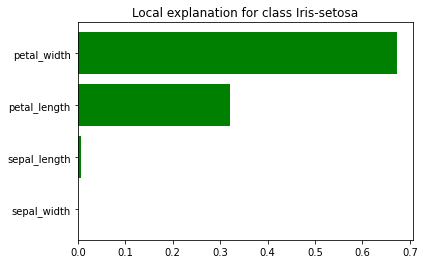

In [7]:
explanation = explainer.explain_instance(
    test_x.ravel(),
    model.predict_proba,
    num_features = 4,
    top_labels = 3
)
explanation.as_pyplot_figure(explanation.top_labels[0])
explanation.predict_proba   # probabilites from explained model

In [8]:
test_data

,sepal_length,sepal_width,petal_length,petal_width,label
49,5.0,3.3,1.4,0.2,Iris-setosa


In [9]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))

[1.0, 0.0, 0.0]
[0.9925494198030188, 0.004187355810214022, 0.005818809276464847]
[0.9900193, 0.004176682, 0.0058039767]


In [10]:
print("MSE on training set:", np.array(explanation.get_losses_for_surrogate_model()))
print("MSE on cv-test  set:", np.mean(explanation.get_losses_for_cv_model(), axis=1))
print("std on cv-test  set:", np.std(explanation.get_losses_for_cv_model(), axis=1))

MSE on training set: [0.00084697 0.0085341  0.00479339]
MSE on cv-test  set: [0.00091541 0.00872595 0.00509052]
std on cv-test  set: [8.17195344e-05 6.96595111e-04 4.61844861e-04]


In [11]:
explanation.get_predicted_label()

'Iris-setosa'

In [19]:
explanation.render_explanation_tree("../data/img/tree_explanation/tree_multiregressor.png")

In [13]:
print(explanation.get_decision_rules_for_explanation())

Sklasyfikowano jako 'Iris-setosa', ponieważ:
		cecha petal_width (o wartości 0.2) była <= 0.798
	oraz	cecha petal_length (o wartości 1.4) była <= 2.46
	oraz	cecha petal_width (o wartości 0.2) była <= 0.703
	oraz	cecha sepal_length (o wartości 5.0) była <= 5.447



In [14]:
explanation.get_fidelity_loss_on_kfold()


array([0.00407034, 0.00353954, 0.00361923, 0.00393431, 0.00458272])